<a href="https://colab.research.google.com/github/SaswatoB/Data-Science-Engineering-Methods/blob/main/Rice_Classification_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-ML Assignment

In [2]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

!pip uninstall h2o


!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 176.0 MB 6.5 kB/s 
  Created wheel for h2o: filename=h2o-3.36.0.2-py2.py3-none-any.whl size=176112127 sha256=b99590ca3c53fe8b93d316d1751d50e97ce4afcacae798ceff2f4179a680fb18
  Stored in directory: /root/.cache/pip/wheels/0b/83/bd/343a6140119b4098103e725e1cfe9f198568d13cf103acbc7c
Successfully built h2o


In [3]:
# Import libraries
# Use pip install or conda install if missing a library
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

In [5]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [6]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:49041 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2_rlha2i
  JVM stdout: /tmp/tmp2_rlha2i/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2_rlha2i/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:49041
Connecting to H2O server at http://127.0.0.1:49041 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_unknownUser_tv1qhu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [7]:
from google.colab import files
uploaded = files.upload()


Saving riceClassification.csv to riceClassification.csv


In [8]:
print (uploaded['riceClassification.csv'][:200].decode('utf-8') + '...')

id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
1,4537,92.2293165,64.01276874,0.7199162256,4677,76.00452496,0.6575362319,273...


In [9]:
import io

df1 = pd.read_csv(io.StringIO(uploaded['riceClassification.csv'].decode('utf-8')))
df = h2o.H2OFrame(df1)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [10]:
df.head()

id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
1,4537,92.2293,64.0128,0.719916,4677,76.0045,0.657536,273.085,0.76451,1.4408,1
2,2872,74.6919,51.4005,0.725553,3015,60.471,0.713009,208.317,0.831658,1.45314,1
3,3048,76.2932,52.0435,0.731211,3132,62.2963,0.759153,210.012,0.868434,1.46595,1
4,3073,77.0336,51.9285,0.738639,3157,62.5513,0.783529,210.657,0.870203,1.48346,1
5,3693,85.1248,56.374,0.749282,3802,68.5717,0.769375,230.332,0.874743,1.51,1
6,2990,77.4171,50.9543,0.752861,3080,61.7008,0.584898,216.93,0.798439,1.51934,1
7,3556,84.3236,55.4131,0.753762,3636,67.2877,0.750211,227.007,0.867148,1.52173,1
8,3788,86.9524,56.4448,0.760664,3866,69.448,0.800676,235.476,0.858473,1.54049,1
9,2629,74.1331,48.0741,0.761228,2790,57.8563,0.640595,207.325,0.768594,1.54206,1
10,5719,106.721,68.9777,0.763053,5819,85.3326,0.754983,281.839,0.904748,1.54718,1


In [11]:
df.types

{'Area': 'int',
 'AspectRation': 'real',
 'Class': 'int',
 'ConvexArea': 'int',
 'Eccentricity': 'real',
 'EquivDiameter': 'real',
 'Extent': 'real',
 'MajorAxisLength': 'real',
 'MinorAxisLength': 'real',
 'Perimeter': 'real',
 'Roundness': 'real',
 'id': 'int'}

In [12]:
print('Total Number of rows:', df.shape[0] )
print('Total Number of columns:', df.shape[1] )

Total Number of rows: 18185
Total Number of columns: 12


In [13]:
df.describe()

Rows:18185
Cols:12




,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
type,int,int,real,real,real,int,real,real,real,real,real,int
mins,1.0,2522.0,74.13311404,34.40989421,0.6766470565,2579.0,56.66665803,0.3832391714,197.015,0.1745901779,1.358128195,0.0
mean,9093.0,7036.492988726975,151.68075388107974,59.8078511594407,0.9154063539308258,7225.8178718724475,94.13295239997858,0.6166528250536815,351.60694924387997,0.7079983422321539,2.599081089354609,0.5490789111905416
maxs,18185.0,10210.0,183.2114344,82.55076212,0.9667736672,11008.0,114.0165591,0.8865730584,508.511,0.9047483132,3.911844673,1.0
sigma,5249.70165818973,1467.1971501530709,12.37640247521008,10.061652559363003,0.030575132488674692,1502.0065711989255,9.906250469738056,0.10438942430267777,29.500619875939645,0.06731016002659125,0.4348364637403783,0.497599112099058
zeros,0,0,0,0,0,0,0,0,0,0,0,8200
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,4537.0,92.2293165,64.01276874,0.7199162256,4677.0,76.00452496,0.6575362319,273.085,0.7645096145,1.440795615,1.0
1,2.0,2872.0,74.69188071,51.40045446,0.7255527468,3015.0,60.47101762,0.7130089374,208.317,0.8316582009,1.453136582,1.0
2,3.0,3048.0,76.2931638,52.04349114,0.7312109273,3132.0,62.29634124,0.7591531756,210.012,0.8684335737,1.465950153,1.0


In [14]:
# Create a 80/20 train/test splie
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

In [15]:
print(df_train.shape, df_test.shape)

(14549, 12) (3636, 12)


In [16]:
df_train.head()

id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
1,4537,92.2293,64.0128,0.719916,4677,76.0045,0.657536,273.085,0.76451,1.4408,1
2,2872,74.6919,51.4005,0.725553,3015,60.471,0.713009,208.317,0.831658,1.45314,1
3,3048,76.2932,52.0435,0.731211,3132,62.2963,0.759153,210.012,0.868434,1.46595,1
5,3693,85.1248,56.374,0.749282,3802,68.5717,0.769375,230.332,0.874743,1.51,1
6,2990,77.4171,50.9543,0.752861,3080,61.7008,0.584898,216.93,0.798439,1.51934,1
7,3556,84.3236,55.4131,0.753762,3636,67.2877,0.750211,227.007,0.867148,1.52173,1
8,3788,86.9524,56.4448,0.760664,3866,69.448,0.800676,235.476,0.858473,1.54049,1
9,2629,74.1331,48.0741,0.761228,2790,57.8563,0.640595,207.325,0.768594,1.54206,1
11,2665,74.364,48.0532,0.763178,2777,58.251,0.596731,202.456,0.817045,1.54754,1
12,3231,81.3042,52.4511,0.76408,3330,64.1392,0.61496,218.773,0.848319,1.55009,1


In [17]:
#Setting predictor and Target variables
X= df.columns
y= 'Class'
X.remove(y)
X

['id',
 'Area',
 'MajorAxisLength',
 'MinorAxisLength',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Extent',
 'Perimeter',
 'Roundness',
 'AspectRation']

# Setting up the model
AutoML will automatically predict whether to perform classification or regression based on the target parameter's data type

In [18]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [19]:
aml.train(x=X,y=y,training_frame=df_train)  

AutoML progress: |
03:22:05.552: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

█████████
03:22:35.627: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

█
03:22:39.646: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

██████████████████████████████
03:24:27.695: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the res

,,number_of_trees
0,,79.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 2.8922556576377073e-07
RMSE: 0.000537796955889275
MAE: 0.000145695591982357
RMSLE: 0.00043708935212541735
Mean Residual Deviance: 2.8922556576377073e-07

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 1.1481541694235036e-05
RMSE: 0.0033884423699149786
MAE: 0.0004998929611685612
RMSLE: 0.0029679186759224638
Mean Residual Deviance: 1.1481541694235036e-05

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.000500,0.000288,0.000360,0.000713,2.075403e-04,0.000328,0.000891
1,mean_residual_deviance,0.000011,0.000009,0.000019,0.000014,8.653652e-07,0.000002,0.000021
2,mse,0.000011,0.000009,0.000019,0.000014,8.653652e-07,0.000002,0.000021
3,r2,0.999954,0.000038,0.999923,0.999943,9.999965e-01,0.999991,0.999915
4,residual_deviance,0.000011,0.000009,0.000019,0.000014,8.653652e-07,0.000002,0.000021
5,rmse,0.003028,0.001701,0.004364,0.003758,9.302500e-04,0.001484,0.004602
6,rmsle,0.002635,0.001527,0.003945,0.003273,6.918326e-04,0.001322,0.003942



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-02-05 03:22:30,25.330 sec,0.0,0.500000,0.500000,2.500000e-01
1,,2022-02-05 03:22:30,25.443 sec,5.0,0.084174,0.084167,7.085322e-03
2,,2022-02-05 03:22:31,25.554 sec,10.0,0.014653,0.014391,2.147232e-04
3,,2022-02-05 03:22:31,25.691 sec,15.0,0.003110,0.002563,9.674821e-06
4,,2022-02-05 03:22:31,25.910 sec,20.0,0.001583,0.000622,2.506962e-06
5,,2022-02-05 03:22:31,26.168 sec,25.0,0.001288,0.000288,1.658829e-06
6,,2022-02-05 03:22:32,26.458 sec,30.0,0.001100,0.000220,1.210976e-06
7,,2022-02-05 03:22:32,26.724 sec,35.0,0.000987,0.000207,9.747727e-07
8,,2022-02-05 03:22:32,27.024 sec,40.0,0.000893,0.000194,7.966540e-07
9,,2022-02-05 03:22:32,27.332 sec,45.0,0.000809,0.000182,6.550192e-07



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,AspectRation,2311.197998,1.000000,0.545574
1,Eccentricity,915.922852,0.396298,0.216210
2,id,571.004700,0.247060,0.134789
3,MinorAxisLength,436.673004,0.188938,0.103080
4,Roundness,0.944760,0.000409,0.000223
5,Area,0.275803,0.000119,0.000065
6,Perimeter,0.095619,0.000041,0.000023
7,EquivDiameter,0.071930,0.000031,0.000017
8,ConvexArea,0.057683,0.000025,0.000014
9,Extent,0.015024,0.000007,0.000004


In [20]:
print(aml.leaderboard)


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_1_AutoML_1_20220205_32205,1.14815e-05,0.00338844,1.14815e-05,0.000499893,0.00296792
StackedEnsemble_AllModels_2_AutoML_1_20220205_32205,1.24815e-05,0.00353291,1.24815e-05,0.000920683,0.00308974
StackedEnsemble_BestOfFamily_2_AutoML_1_20220205_32205,1.24861e-05,0.00353356,1.24861e-05,0.000936266,0.00306313
StackedEnsemble_BestOfFamily_3_AutoML_1_20220205_32205,1.25022e-05,0.00353585,1.25022e-05,0.000936262,0.00306559
StackedEnsemble_AllModels_1_AutoML_1_20220205_32205,1.25707e-05,0.00354552,1.25707e-05,0.000920641,0.00308369
StackedEnsemble_BestOfFamily_1_AutoML_1_20220205_32205,1.40571e-05,0.00374928,1.40571e-05,0.00117414,0.00305505
GBM_2_AutoML_1_20220205_32205,4.12613e-05,0.0064235,4.12613e-05,0.0011478,0.00514989
XGBoost_3_AutoML_1_20220205_32205,7.49725e-05,0.00865867,7.49725e-05,0.000533379,0.00693301
GBM_4_AutoML_1_20220205_32205,8.73473e-05,0.00934598,8.73473e-05,0.00187389,0.00744233
GBM_1_AutoML_1_20220205_32205,8.92328e-05,0.00944631,8.92328e-05,0.00260293,0.00658428


In [21]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'GLM_1_AutoML_1_20220205_32205': 14, 'XGBoost_1_AutoML_1_20220205_32205': 0}

In [22]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

0


In [23]:
best_model.algo

'xgboost'

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

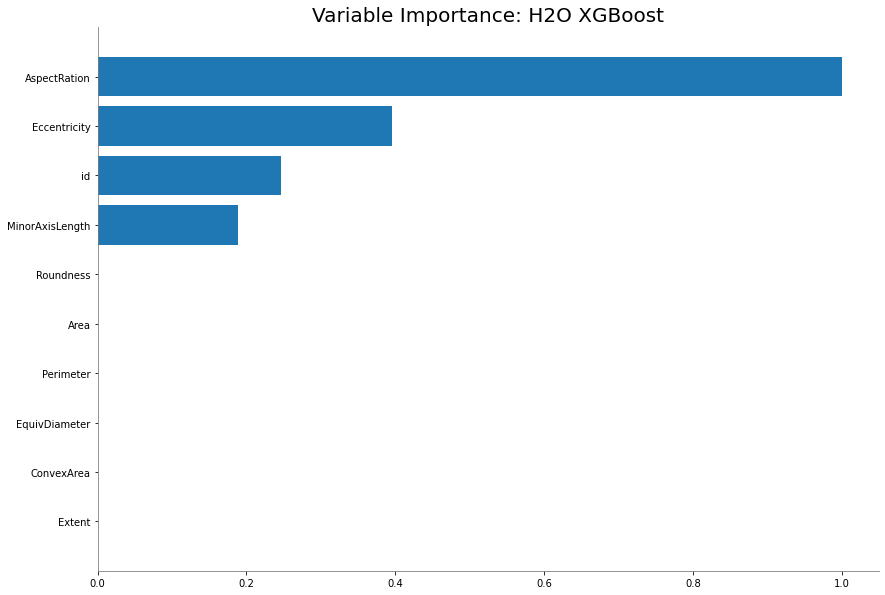

<Figure size 432x288 with 0 Axes>

In [25]:
if best_model.algo in ['gbm','drf','xrt','xgboost']:
  best_model.varimp_plot()

14
glm


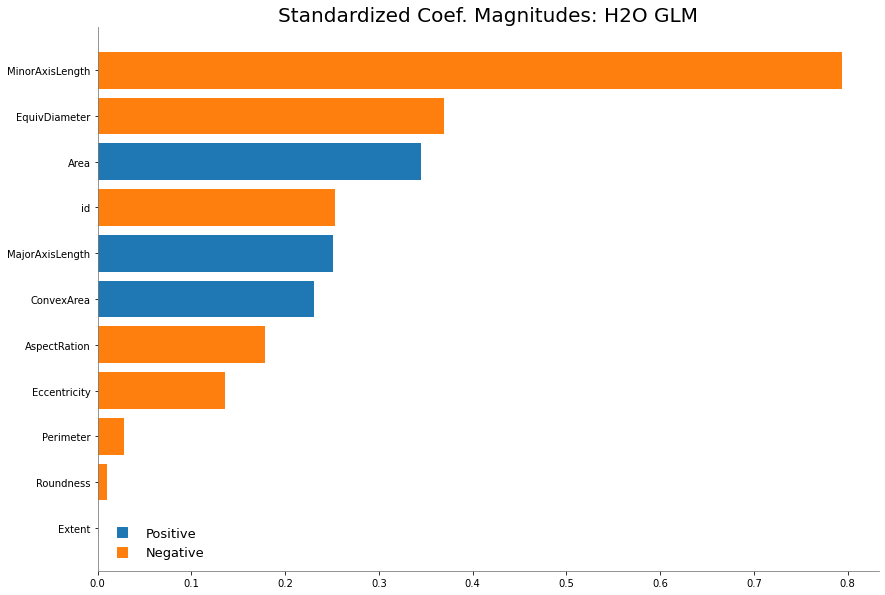

In [26]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo) 
  glm_model.std_coef_plot()

In [27]:
print(best_model.rmse(train = True))

0.000537796955889275


In [28]:
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [29]:
mod_perf=best_model.model_performance(df_test)
stats_test={}
stats_test=model_performance_stats(mod_perf)
stats_test

{'mse': 4.278355566484237e-06,
 'null_degrees_of_freedom': None,
 'null_deviance': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'rmse': 0.0020684186149046904}

In [30]:
predictions = best_model.predict(df_test)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [31]:
y_pred=h2o.as_list(predictions)
y_pred[0:5]

,predict
0,1.001541
1,0.991495
2,0.999112
3,1.000566
4,1.003791


In [32]:
y_test=h2o.as_list(df_test[y])
y_test[0:5]

,Class
0,1
1,1
2,1
3,1
4,1


In [33]:
print(X)

['id', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness', 'AspectRation']


PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'MinorAxisLength'.


,minoraxislength,mean_response,stddev_response,std_error_mean_response
0,34.409894,0.597233,0.449650,0.003334
1,36.943624,0.597233,0.449650,0.003334
2,39.477354,0.595605,0.449895,0.003336
3,42.011084,0.595526,0.450061,0.003337
4,44.544814,0.595526,0.450061,0.003337
5,47.078544,0.595526,0.450061,0.003337
6,49.612274,0.595526,0.450061,0.003337
7,52.146003,0.595525,0.450061,0.003337
8,54.679733,0.595432,0.449996,0.003337
9,57.213463,0.559481,0.473211,0.003509


[]

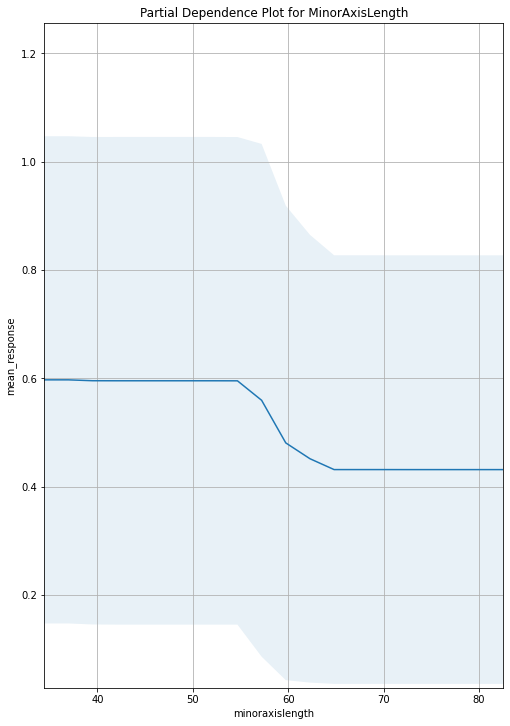

In [34]:
best_model.partial_plot(df, cols=['MinorAxisLength'])

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'MajorAxisLength'.


,majoraxislength,mean_response,stddev_response,std_error_mean_response
0,74.133114,0.542662,0.502044,0.003723
1,79.874078,0.542662,0.502044,0.003723
2,85.615042,0.542662,0.502044,0.003723
3,91.356007,0.542667,0.502049,0.003723
4,97.096971,0.542531,0.501910,0.003722
5,102.837935,0.542690,0.501868,0.003722
6,108.578899,0.542676,0.501860,0.003722
7,114.319864,0.542733,0.501854,0.003722
8,120.060828,0.542675,0.501795,0.003721
9,125.801792,0.549509,0.499155,0.003702



PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'MinorAxisLength'.


,minoraxislength,mean_response,stddev_response,std_error_mean_response
0,34.409894,0.597233,0.449650,0.003334
1,36.943624,0.597233,0.449650,0.003334
2,39.477354,0.595605,0.449895,0.003336
3,42.011084,0.595526,0.450061,0.003337
4,44.544814,0.595526,0.450061,0.003337
5,47.078544,0.595526,0.450061,0.003337
6,49.612274,0.595526,0.450061,0.003337
7,52.146003,0.595525,0.450061,0.003337
8,54.679733,0.595432,0.449996,0.003337
9,57.213463,0.559481,0.473211,0.003509



PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'Eccentricity'.


,eccentricity,mean_response,stddev_response,std_error_mean_response
0,0.676647,0.436104,0.399771,0.002965
1,0.691917,0.436104,0.399771,0.002965
2,0.707187,0.436104,0.399771,0.002965
3,0.722457,0.435465,0.399771,0.002965
4,0.737726,0.435508,0.399546,0.002963
5,0.752996,0.435015,0.399308,0.002961
6,0.768266,0.435203,0.399304,0.002961
7,0.783536,0.435061,0.399303,0.002961
8,0.798806,0.435061,0.399303,0.002961
9,0.814075,0.435075,0.399314,0.002961



PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'ConvexArea'.


,convexarea,mean_response,stddev_response,std_error_mean_response
0,2579.000000,0.544485,0.502759,0.003728
1,3022.631579,0.544485,0.502759,0.003728
2,3466.263158,0.544485,0.502759,0.003728
3,3909.894737,0.544480,0.502755,0.003728
4,4353.526316,0.544351,0.502821,0.003729
5,4797.157895,0.543938,0.502933,0.003730
6,5240.789474,0.543982,0.502955,0.003730
7,5684.421053,0.543998,0.502845,0.003729
8,6128.052632,0.549284,0.497551,0.003690
9,6571.684211,0.549629,0.497226,0.003687



PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'EquivDiameter'.


,equivdiameter,mean_response,stddev_response,std_error_mean_response
0,56.666658,0.552161,0.494136,0.003664
1,59.685074,0.552161,0.494136,0.003664
2,62.703490,0.552161,0.494136,0.003664
3,65.721906,0.552160,0.494135,0.003664
4,68.740321,0.552160,0.494135,0.003664
5,71.758737,0.552167,0.494141,0.003664
6,74.777153,0.552155,0.494139,0.003664
7,77.795569,0.552158,0.494142,0.003664
8,80.813985,0.552154,0.494139,0.003664
9,83.832401,0.552154,0.494138,0.003664



PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'Extent'.


,extent,mean_response,stddev_response,std_error_mean_response
0,0.383239,0.550341,0.496209,0.003680
1,0.409730,0.550341,0.496209,0.003680
2,0.436222,0.550341,0.496209,0.003680
3,0.462713,0.550341,0.496209,0.003680
4,0.489204,0.550344,0.496212,0.003680
5,0.515695,0.549971,0.496607,0.003683
6,0.542187,0.549005,0.497607,0.003690
7,0.568678,0.549044,0.497624,0.003690
8,0.595169,0.549050,0.497580,0.003690
9,0.621660,0.549056,0.497572,0.003690



PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'Perimeter'.


,perimeter,mean_response,stddev_response,std_error_mean_response
0,197.015000,0.549171,0.497868,0.003692
1,213.409526,0.549171,0.497868,0.003692
2,229.804053,0.549171,0.497868,0.003692
3,246.198579,0.549281,0.497859,0.003692
4,262.593105,0.549251,0.498004,0.003693
5,278.987632,0.549295,0.498044,0.003693
6,295.382158,0.549345,0.498091,0.003694
7,311.776684,0.549468,0.497409,0.003689
8,328.171211,0.549267,0.497665,0.003690
9,344.565737,0.549105,0.497750,0.003691



PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'Roundness'.


,roundness,mean_response,stddev_response,std_error_mean_response
0,0.174590,0.549337,0.497364,0.003688
1,0.213020,0.549337,0.497364,0.003688
2,0.251449,0.549337,0.497364,0.003688
3,0.289878,0.549337,0.497364,0.003688
4,0.328308,0.549337,0.497364,0.003688
5,0.366737,0.549337,0.497364,0.003688
6,0.405166,0.549337,0.497364,0.003688
7,0.443596,0.549337,0.497364,0.003688
8,0.482025,0.549337,0.497364,0.003688
9,0.520455,0.549337,0.497364,0.003688



PartialDependence: Partial Dependence Plot of model XGBoost_1_AutoML_1_20220205_32205 on column 'AspectRation'.


,aspectration,mean_response,stddev_response,std_error_mean_response
0,1.358128,0.317086,0.316690,0.002348
1,1.492534,0.316852,0.316634,0.002348
2,1.626940,0.316490,0.316649,0.002348
3,1.761347,0.316792,0.316791,0.002349
4,1.895753,0.316941,0.316814,0.002349
5,2.030159,0.316949,0.316823,0.002349
6,2.164565,0.316900,0.316815,0.002349
7,2.298971,0.316898,0.316793,0.002349
8,2.433377,0.317087,0.316794,0.002349
9,2.567783,0.678775,0.389022,0.002885


[, , , , , , , , ]

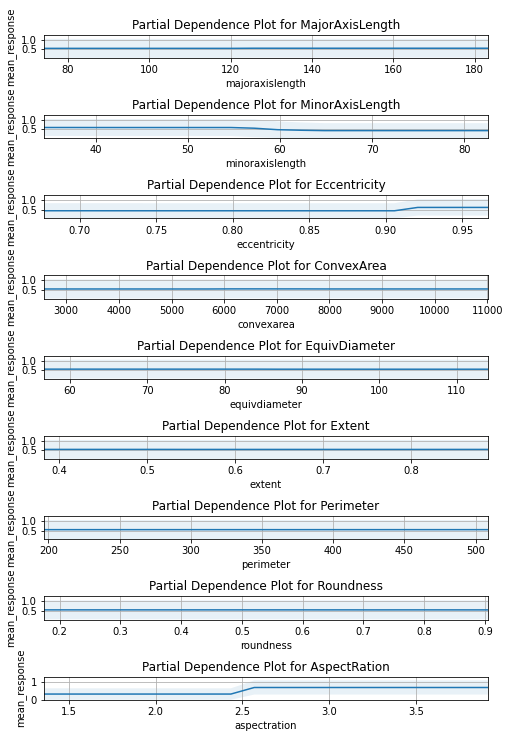

In [35]:
best_model.partial_plot(df, cols=['MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness', 'AspectRation'])

In [36]:
h2o.cluster().shutdown()

H2O session _sid_af33 closed.
